# Max-Product Belief Propagation on chain structured Markov Random Fields for Vehicle Localization

Let's consider an autonomous vehicle driving on a highway and tracking a vehicle in front in order to initiate an overtaking maneuver. Let $x_t\in\{1,2,3\}$ denote the lane the vehicle in front is driving on at time $t\in\{1,\dots,10\}$. Unfortunately, the sensor readings are noisy as depicted below.
<img src="gfx/car_on_lane_map_unary_1.png" width="500"/>


Selecting the most likely lane at each time $t$ independently (green) leads to wrong estimates for $t=\{3,7,10\}$. To solve this problem, and recover the correct situation depicted below
<img src="gfx/car_on_lane.png" width="500"/>

we can integrate prior knowledge and infer the most likely situation using max-product belief propagation. A sensible prior would favor staying on the same lane over changing one lane at a time over changing two lanes at a time. This prior can be integrated via a pairwise, chain-structured Markov Random Fields (also called: Hidden Markov Model or HMM) where pairwise factors between adjacent frames modulate transition likelihoods:
<img src="gfx/chain_10_nodes.png" width="400"/>

$$g_\theta(x_i,x_{i+1}) = \begin{bmatrix}0.8 & 0.2 & 0.0\\ 0.2 & 0.6 & 0.2 \\ 0.0 & 0.2 & 0.8\end{bmatrix}$$
$$ p_\theta({\bf x}) \propto \prod_{1}^{10} f_i(x_i)\prod_{1}^{9}g_{\theta}(x_i, x_{i+1})$$

Your task is to complete the code by implementing the specialized algorithm for max-product belief propagation on chain-structured Markov random field using backtracking. 

Let's first import the modules needed and define a helper function:

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc

# plot function
# input: Nx3 matrix of values & title string
def plot(vals,title=''):
    plt.close()
    vals /= np.tile(np.sum(vals,1),(3,1)).transpose()
    f, axarr = plt.subplots(1,10,figsize=(10,2))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    for i in range(vals.shape[0]):
        axarr[i].barh([0,1,2],np.array([1,1,1]),color='white',edgecolor='black',linewidth=2)
        axarr[i].barh([0,1,2],vals[i],color='red')
        axarr[i].axis('off')
    plt.show()

And define the potentials:

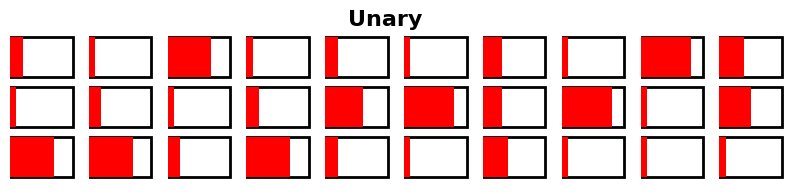

In [2]:
# unary: Nx3 matrix specifying unary likelihood of each state
unary = np.array([[0.7,0.1,0.2],[0.7,0.2,0.1],[0.2,0.1,0.7],[0.7,0.2,0.1],
                  [0.2,0.6,0.2],[0.1,0.8,0.1],[0.4,0.3,0.3],[0.1,0.8,0.1],
                  [0.1,0.1,0.8],[0.1,0.5,0.4]])
# pairwise: 3x3 matrix specifying transition probabilities (rows=t -> columns=t+1)
pairwise = np.array([[0.8,0.2,0.0],[0.2,0.6,0.2],[0.0,0.2,0.8]])

# plot unaries
plot(unary,'Unary')

### Task 1

Implement the computation of the messages between the variables below.

In [3]:
# model parameters (number of variables/states)
[num_vars,num_states] = unary.shape

# compute messages
msg = np.zeros([num_vars-1, num_states]) # (num_vars-1) x num_states matrix
for i in range(num_vars-2, -1, -1):
    if i == num_vars-2:
        msg[i, :] = np.max(pairwise*unary[i+1, :], 1)
    else:
        msg[i, :] = np.max(pairwise*unary[i+1, :]*msg[i+1, :],1)

### Task 2

Use dynamic programming to calculate and plot the MAP solution.

**Outputs:**
 * `max_marginals`: `num_vars` x `num_states` array of estimated max-marginals
 * `map`: array comprising the estimated MAP state of each variable

In [4]:
# calculate max-marginals (num_vars x num_states matrix) and MAP estimates (num_vars x 1 matrix)
max_marginals = np.zeros([num_vars,num_states])
map = np.zeros(num_vars, dtype=int)
for i in range(num_vars):
    if i == 0:
        max_marginals[i,:] = msg[i, :]
    if i == num_vars-1:
        max_marginals[i,:] = pairwise[map[i-1],:]*unary[i,:]
    else:
        max_marginals[i,:] = pairwise[map[i-1],:]*unary[i,:]*msg[i, :]
    map[i] = np.argmax(max_marginals[i, :])

Visualize and print the results:

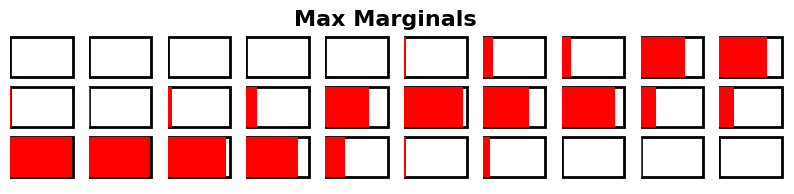

MAP Estimate:
[0 0 0 0 1 1 1 1 2 2]


In [5]:
# plot max-marginals
plot(max_marginals,'Max Marginals')

# print MAP state
print("MAP Estimate:")
print(np.argmax(max_marginals,axis=1))
